In [1]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_colab = None

Train Images


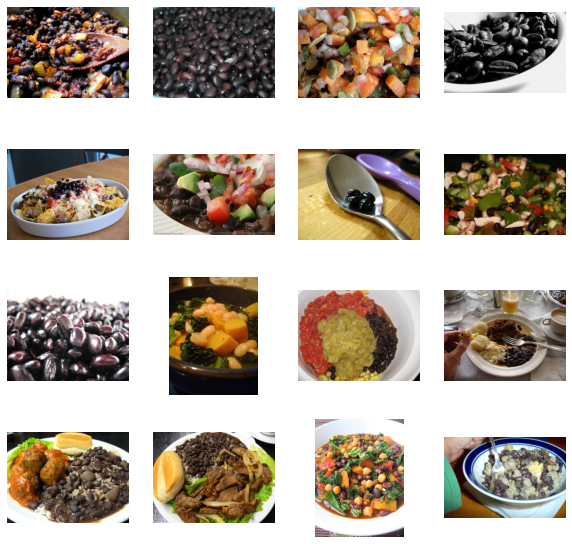

In [2]:
train_path = 'images/train/'
val_path = 'images/val/'

print("Train Images")
train_paths = glob.glob(train_path + "/**/*.jpg") # Grabbing all the image file names
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

Validation Images


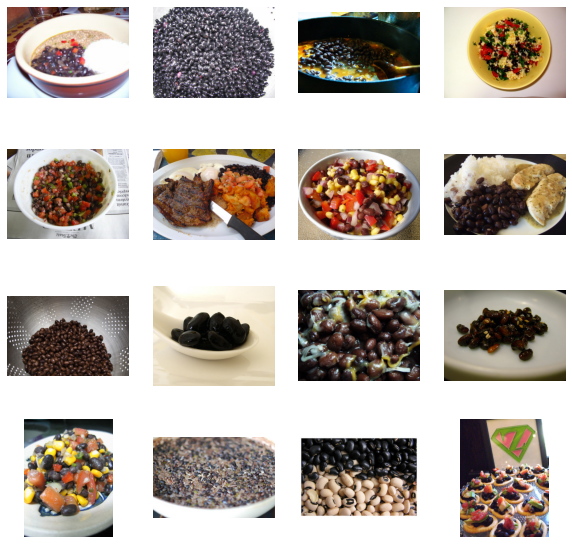

In [3]:
print("Validation Images")
val_paths = glob.glob(val_path + "/**/*.jpg") # Grabbing all the image file names
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), val_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

In [4]:
SIZE = 256
class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(), # A little data augmentation!
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)
        
        self.split = split
        self.size = SIZE
        self.paths = paths
        self.labels = list(set([value.split('\\')[1] for value in paths]))
        self.class_to_idx = {j:i for i, j in enumerate(self.labels)}
        
    
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1
        label = self.paths[idx].split("\\")[1]
        idx = self.class_to_idx[label]
        
        return {'L': L, 'ab': ab, "label": idx}
    
    def __len__(self):
        return len(self.paths)

def make_dataloaders(batch_size=16, n_workers=0, pin_memory=True, **kwargs): # A handy function to make our dataloaders
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,
                            pin_memory=pin_memory, shuffle=True)
    return dataloader

In [5]:
train_dl = make_dataloaders(paths=train_paths, split='train')
val_dl = make_dataloaders(paths=val_paths, split='val')

data = next(iter(train_dl))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)
print(len(train_dl), len(val_dl))

C:\Users\EG\miniconda3\envs\DeepLearners2021\lib\site-packages\torchvision\transforms\transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256])
134 34


Feature batch shape: torch.Size([16, 1, 256, 256])
Labels batch shape: torch.Size([16, 2, 256, 256])


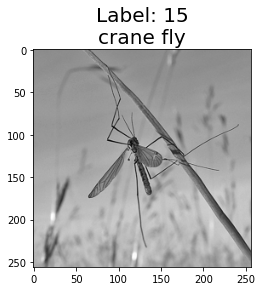

In [9]:
data = next(iter(train_dl))
classes = list(set([value.split('\\')[1] for value in val_paths]))

Ls, abs_ = data['L'], data['ab']
print(f"Feature batch shape: {Ls.size()}")
print(f"Labels batch shape: {abs_.size()}")
img = Ls[0].squeeze()
label = data["label"][0]
plt.imshow(img, cmap="gray")
plt.title(f"Label: {label}\n{classes[label]}", size=20)
plt.show()